# Training ML algos on EPH. Predicting on CENSO.

In [1]:
yr = '2020'

In [21]:
# Load modules
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.core.display import display, HTML

import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os

In [22]:
# Column names
y_cols = ['CAT_OCUP', 'P47T', 'PP10E', 'PP10D', 'PP07K', 'PP07I', 'V3_M', 'PP07G4', 'CH16', 'T_VI', 
          'V12_M', 'TOT_P12', 'PP07G3', 'V5_M', 'PP07H', 'V2_M', 'PP10C', 
          'PP08D1', 'PP07J', 'CAT_INAC', 'CH07', 'CH08', 'P21', 'PP07G1', 'PP07G_59', 'PP07G2']


x_cols = ['IX_TOT', 'P02', 'P03', 'AGLO_rk', 'Reg_rk', 'V01', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
       'H13', 'P07', 'P08', 'P09', 'P10', 'P05', 'CONDACT']

x_cols1 = x_cols
predecir1 = ['CAT_OCUP', 'CAT_INAC', 'CH07']

x_cols2 = x_cols1 + predecir1
predecir2 = ['INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS']

x_cols3 = x_cols2 + predecir2
# La seccion PP07G pregunta si el trabajo es en blanco y que beneficios tiene. Puede ayudar a la regresion para ingresos.
# predecir3 = ['PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K']
predecir3 = ['PP07G1','PP07G_59', 'PP07I', 'PP07J', 'PP07K']

# Columnas de ingresos. Necesitan una regresion...
columnas_pesos = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']
# P21: INGRESO DE LA OCUPACIÓN PRINCIPAL 
# P47T: TOTAL (laboral y no laboral)
# PP08D1: Sueldos, jornales, etc.
# TOT_P12: TOTAL DE INGRESO  POR  OTRAS OCUPACIONES (Secundaria, previa...)
# T_VI: TOTAL DE INGRESOS NO LABORALES
# V12_M:  CUOTAS DE ALIMENTOS O AYUDA EN DINERO  DE PERSONAS QUE NO VIVEN EN EL HOGAR 
# V2_M: ingreso por JUBILACION O PENSION
# V3_M: INDEMNIZACION POR DESPIDO 
# V5_M: SUBSIDIO  O AYUDA SOCIAL DEL GOBIERNO, IGLESIAS, ETC.

### Load info

In [23]:
radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./../data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)

AGLO_rk = pd.read_csv('./../data/info/AGLO_rk')
Reg_rk = pd.read_csv('./../data/info/Reg_rk')

In [24]:
frac = 0.02

# Error en test set

In [25]:
## Usando la notacion:
# True Positives (TP)
# True Negatives (TN)
# False Positives (FP)
# False Negatives (FN)

# Tenemos que:
# Precision = TP/TP+FP
# Baja precision significa que metemos muchos en esta clase.

# Recall = TP/TP+FN
# Bajo recall significa que no pudimos detectar la clase

# F1 Score = 2*(Recall * Precision) / (Recall + Precision)
# Promedio ponderado de precision y recall

In [26]:
from sklearn.metrics import classification_report
varnames = pd.read_csv('./../data/info/VARIABLE_NAMES.csv')

In [30]:
train_data = pd.read_csv('./../data/training/EPHARG_train_'+yr[2:]+'.csv')
train_data = train_data.loc[train_data.P47T >= -0.001].fillna(0)#.sample(400000) # remove entries with bad data (almost none)
train_data = train_data.sort_values('CODUSU') ## Esto es porque los hogares se repiten en cada cuatrimestre, y entonces se da un overfitting, 
# es decir, las predicciones en test set van a ser muy buenas porque ya se observo a la misma gente en el trimestre anterior

### STEP 1
x_cols1 = x_cols
y_cols1 = predecir1

X = train_data[x_cols1]
y = train_data[y_cols1]#.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# Rewrite Census data as 'test' set.

# ## Cargar Modelo
# filename = './../fitted_RF/clf1_'+str(frac)+'_'+yr+'_ARG.sav'
# clf1 = pickle.load(open(filename, 'rb'))

forest = RandomForestClassifier(n_estimators=70, max_depth = 35, n_jobs = -1)
clf1 = forest.fit(X_train.values, y_train.values)

In [31]:
y_out1 = clf1.predict(X_test[x_cols1].values)
y_censo_fit1 = pd.DataFrame(y_out1, index = X_test.index, columns=predecir1)

In [32]:
for col in y_test.columns:
    print(col)
    print(varnames.loc[varnames.EPH == col].Pregunta.values[0])
    print(classification_report(y_test[col], y_censo_fit1[col]))
    freqs = pd.DataFrame(pd.concat([y_test[col].value_counts()/len(y_test), y_censo_fit1[col].value_counts()/len(y_test)], axis = 1)); freqs.columns = ['true', 'predicted']
    display(100*freqs.round(3))
    print('******************')

CAT_OCUP
Cat ocupacional (patron/obrero/etc)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10314
           1       0.79      0.53      0.64       180
           2       0.91      0.67      0.78      1480
           3       0.89      0.98      0.93      4901
           4       0.96      0.49      0.65        47

    accuracy                           0.96     16922
   macro avg       0.91      0.73      0.80     16922
weighted avg       0.96      0.96      0.96     16922



,true,predicted
0,61.0,60.8
3,29.0,31.9
2,8.7,6.4
1,1.1,0.7
4,0.3,0.1


******************
CAT_INAC
Cat inactivo (jubilado/rentista/estudiante)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6728
           1       0.96      0.97      0.97      2457
           2       0.90      0.47      0.62        19
           3       1.00      1.00      1.00      4368
           4       0.92      0.94      0.93      1422
           5       1.00      1.00      1.00      1475
           6       0.95      0.64      0.77        64
           7       0.89      0.81      0.85       389

    accuracy                           0.98     16922
   macro avg       0.95      0.85      0.89     16922
weighted avg       0.98      0.98      0.98     16922



,true,predicted
0,39.8,39.8
3,25.8,25.9
1,14.5,14.6
5,8.7,8.7
4,8.4,8.6
7,2.3,2.1
6,0.4,0.3
2,0.1,0.1


******************
CH07
estado civil
              precision    recall  f1-score   support

           1       0.90      0.86      0.88      2744
           2       0.88      0.93      0.90      3552
           3       0.91      0.75      0.82       952
           4       0.89      0.89      0.89       783
           5       0.97      0.98      0.97      8891

    accuracy                           0.93     16922
   macro avg       0.91      0.88      0.89     16922
weighted avg       0.93      0.93      0.93     16922



,true,predicted
1,16.2,15.5
2,21.0,22.2
3,5.6,4.6
4,4.6,4.6
5,52.5,53.1


******************


## Classification 2
Columna INGRESO

In [11]:
train_data['INGRESO'] = (train_data.P47T > 100).astype(int)
train_data['INGRESO_NLB'] = (train_data.T_VI > 100).astype(int)
train_data['INGRESO_JUB'] = (train_data.V2_M > 100).astype(int)
train_data['INGRESO_SBS'] = (train_data.V5_M > 100).astype(int)

### STEP 2
y_cols2 = predecir2

X = train_data[x_cols2]
y = train_data[y_cols2]#.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

forest = RandomForestClassifier(n_estimators=50, max_depth = 35, n_jobs = -1)
clf2 = forest.fit(X_train.values, y_train.values)


In [12]:

# ## Cargar Modelo
# filename = './../fitted_RF/clf2_'+str(frac)+'_'+yr+'_ARG.sav'
# clf2 = pickle.load(open(filename, 'rb'))

y_out2 = clf2.predict(X_test[x_cols2].values)
y_censo_fit2 = pd.DataFrame(y_out2, index = X_test.index, columns=predecir2)

for col in y_test.columns:
    print(col)
    try:
        print(varnames.loc[varnames.EPH == col].Pregunta.values[0])
    except:
        pass
    print(classification_report(y_test[col], y_censo_fit2[col]))
    freqs = pd.DataFrame(pd.concat([y_test[col].value_counts()/len(y_test), y_censo_fit2[col].value_counts()/len(y_test)], axis = 1)); freqs.columns = ['true', 'predicted']
    display(100*freqs.round(3))
    print('******************')

INGRESO
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3708
           1       0.98      0.98      0.98      4753

    accuracy                           0.98      8461
   macro avg       0.98      0.98      0.98      8461
weighted avg       0.98      0.98      0.98      8461



,true,predicted
1,56.2,56.0
0,43.8,44.0


******************
INGRESO_NLB
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6169
           1       0.98      0.89      0.93      2292

    accuracy                           0.96      8461
   macro avg       0.97      0.94      0.95      8461
weighted avg       0.96      0.96      0.96      8461



,true,predicted
0,72.9,75.3
1,27.1,24.7


******************
INGRESO_JUB
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7078
           1       1.00      0.97      0.98      1383

    accuracy                           0.99      8461
   macro avg       1.00      0.99      0.99      8461
weighted avg       0.99      0.99      0.99      8461



,true,predicted
0,83.7,84.1
1,16.3,15.9


******************
INGRESO_SBS
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7798
           1       0.91      0.68      0.78       663

    accuracy                           0.97      8461
   macro avg       0.94      0.84      0.88      8461
weighted avg       0.97      0.97      0.97      8461



,true,predicted
0,92.2,94.2
1,7.8,5.8


******************


## Classification 3
Columnas ['PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K']

In [13]:
### STEP 3
y_cols3 = predecir3

X = train_data[x_cols3]
y = train_data[y_cols3]#.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

forest = RandomForestClassifier(n_estimators=50, max_depth = 35, n_jobs = -1)
clf3 = forest.fit(X_train.values, y_train.values)


In [14]:
# ## Cargar Modelo
# filename = './../fitted_RF/clf3_'+str(frac)+'_'+yr+'_ARG.sav'
# clf3 = pickle.load(open(filename, 'rb'))

y_out3 = clf3.predict(X_test[x_cols3].values)
y_censo_fit3 = pd.DataFrame(y_out3, index = X_test.index, columns=predecir3)


for col in y_test.columns:
    print(col)
    try:
        print(varnames.loc[varnames.EPH == col].Pregunta.values[0])
    except:
        pass
    print(classification_report(y_test[col], y_censo_fit3[col]))
    freqs = pd.DataFrame(pd.concat([y_test[col].value_counts()/len(y_test), y_censo_fit3[col].value_counts()/len(y_test)], axis = 1)); freqs.columns = ['true', 'predicted']
    display(100*freqs.round(3))
    print('******************')

PP07G1
vacaciones pagas
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6161
         1.0       0.93      0.98      0.95      1600
         2.0       0.95      0.83      0.89       700

    accuracy                           0.98      8461
   macro avg       0.96      0.94      0.95      8461
weighted avg       0.98      0.98      0.98      8461



,true,predicted
0.0,72.8,72.8
1.0,18.9,20.0
2.0,8.3,7.2


******************
PP07G_59
no tiene ninguno
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7826
         5.0       0.95      0.80      0.87       635

    accuracy                           0.98      8461
   macro avg       0.97      0.90      0.93      8461
weighted avg       0.98      0.98      0.98      8461



,true,predicted
0.0,92.5,93.7
5.0,7.5,6.3


******************
PP07I
aporta por si mismpo sist jubilatorio
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7712
         1.0       0.86      0.56      0.68        79
         2.0       0.96      0.86      0.91       670

    accuracy                           0.98      8461
   macro avg       0.93      0.80      0.86      8461
weighted avg       0.98      0.98      0.98      8461



,true,predicted
0.0,91.1,92.3
2.0,7.9,7.1
1.0,0.9,0.6


******************
PP07J
turno dia, noche, etc
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6161
         1.0       0.93      0.99      0.96      2048
         2.0       0.81      0.50      0.62        42
         3.0       0.78      0.36      0.49       210

    accuracy                           0.98      8461
   macro avg       0.88      0.71      0.77      8461
weighted avg       0.98      0.98      0.98      8461



,true,predicted
0.0,72.8,72.8
1.0,24.2,25.8
3.0,2.5,1.1
2.0,0.5,0.3


******************
PP07K
cobra con o sin papel, recibo, factura?
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6161
         1.0       0.92      0.99      0.95      1555
         2.0       0.83      0.49      0.62        41
         3.0       0.91      0.60      0.72        84
         4.0       0.95      0.86      0.91       618
         5.0       1.00      0.50      0.67         2

    accuracy                           0.98      8461
   macro avg       0.94      0.74      0.81      8461
weighted avg       0.98      0.98      0.98      8461



,true,predicted
0.0,72.8,72.8
1.0,18.4,19.7
4.0,7.3,6.6
3.0,1.0,0.7
2.0,0.5,0.3
5.0,0.0,0.0


******************


## Regresion
Combinamos la info de los varios trimestres, deflactada.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

2020-06-30


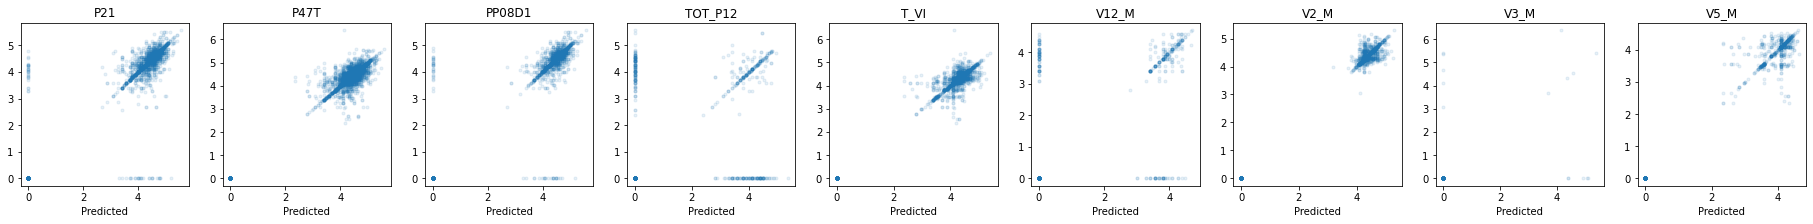

2020-03-31


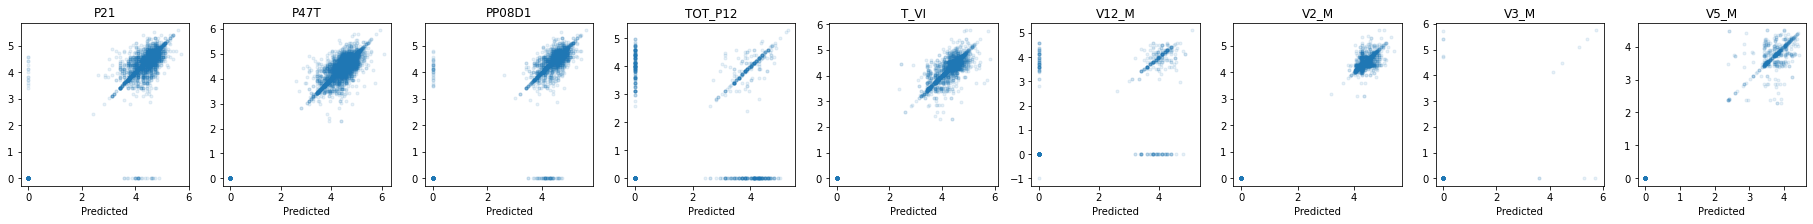

In [19]:
train_data = pd.read_csv('./../data/training/EPHARG_train_'+yr[2:]+'.csv')

train_data = train_data.loc[train_data.P47T >= -0.001].fillna(0)
train_data = train_data.sort_values('CODUSU')


train_data['INGRESO'] = (train_data.P47T > 100).astype(int)
train_data['INGRESO_NLB'] = (train_data.T_VI > 100).astype(int)
train_data['INGRESO_JUB'] = (train_data.V2_M > 100).astype(int)
train_data['INGRESO_SBS'] = (train_data.V5_M > 100).astype(int)

train_data[columnas_pesos] = np.log10(train_data[columnas_pesos].clip(-.9) + 1)

for q in train_data.Q.unique():
    print(q)

    train_q = train_data.loc[train_data.Q == q]

    x_cols4 = x_cols3 + predecir3
    # Columnas de ingresos. Necesitan una regresion...
    predecir4 = columnas_pesos
    y_cols4 = predecir4

    X = train_q[x_cols4]#.sample(frac = 1) #PBA_train_reg
    y = train_q[y_cols4].loc[X.index].fillna(0) #PBA_train_reg

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    forest = RandomForestRegressor(n_estimators=1, max_depth = 60, n_jobs = -1)
    clf4 = forest.fit(X_train.values, y_train.values)
    
    # # save the model to disk
    # filename = './../fitted_RF/clf4_'+str(frac)+'_'+q+'_ARG.sav'
    # pickle.dump(forest, open(filename, 'wb'))

    y_out4 = clf4.predict(X_test[x_cols4].values)
    y_censo_fit4 = pd.DataFrame(y_out4, index = X_test.index, columns=predecir4)
    
    fig, axs = plt.subplots(1, len(y_test.columns), figsize = (32, 3))

    for i, col in enumerate(y_test.columns):
        ax = axs[i]
    #     print(col)
    #     try:
    #         print(varnames.loc[varnames.EPH == col].Pregunta.values[0])
    #     except:
    #         pass

        x = y_test[col].values
        y = y_censo_fit4[col].values

        ax.set_title(col)
        ax.plot(x, y, marker = '.', alpha = .1, lw = 0)
        ax.set_xlabel('True'); ax.set_xlabel('Predicted')

    plt.show()